In [1]:
from sys import path
from os.path import dirname as dir

In [2]:
path.append(dir(path[0]))

In [3]:
from statistics import median
from AgentLayer.ConventionalAgents.LRAgent import LRAgent
from AgentLayer.DataSplitter.TimeSeriesSplitter import TimeSeriesSplitter
from FinancialDataLayer.DataCollection.DataDownloader import DataDownloader
from FinancialDataLayer.DataProcessing.DefaultFeatureEngineer import DefaultFeatureEngineer
from EvaluationLayer.PortfolioEvaluator import PortfolioEvaluator
import yaml
import numpy as np
from AgentLayer.metrics import *

/Users/barisozakar/opt/anaconda3/envs/uniFi/lib/python3.9/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
# IMPORT .yaml FILE
    # Gather user parameters
with open("..//user_params.yaml", "r") as stream:
    try:
        user_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tickers = user_params["TICKERS"]
env_kwargs = user_params["ENV_PARAMS"]
tech_indicator_list = env_kwargs["tech_indicator_list"]

In [5]:
tech_indicator_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [6]:
# FETCH DATA
print("\nTest 3: Downloading from Yahoo.........")
downloaded_df = DataDownloader(start_date='2009-01-01',
                                end_date='2021-10-31',
                                ticker_list=tickers).download_from_yahoo()


Test 3: Downloading from Yahoo.........
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (12924, 8)


In [7]:
downloaded_df

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,2008-12-31,41.590000,43.049999,41.500000,32.005882,5443100,BA,2
2,2008-12-31,43.700001,45.099998,43.700001,30.628824,6277400,CAT,2
3,2008-12-31,72.900002,74.629997,72.900002,43.314445,9964300,CVX,2
4,2009-01-02,3.067143,3.251429,3.041429,2.771174,746015200,AAPL,4
...,...,...,...,...,...,...,...,...
12919,2021-10-28,111.580002,113.269997,111.580002,109.762665,7538200,CVX,3
12920,2021-10-29,147.220001,149.940002,146.410004,149.172195,124953200,AAPL,4
12921,2021-10-29,206.839996,208.240005,205.289993,207.029999,8559500,BA,4
12922,2021-10-29,207.990005,209.750000,203.240005,202.055878,4292200,CAT,4


In [8]:
 # PREPROCESS DATA
print("\nTest 4: Feature engineer.........")
data_processor = DefaultFeatureEngineer(use_default=False,
                                        tech_indicator_list=tech_indicator_list,
                                        use_vix=False,
                                        use_return=True,
                                        use_turbulence=False,
                                        use_covar=False)
# included technical indicators as features
df_processed = data_processor.extend_data(downloaded_df)


Test 4: Feature engineer.........
Successfully added technical indicators
Successfully added returns


In [9]:
df_processed.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,return_list
0,2009-12-31,AAPL,7.611786,7.619643,7.520000,6.434924,352410800.0,3.0,0.105229,6.531584,5.633488,60.410540,155.827531,31.312031,6.105642,6.048183,tic AAPL BA CAT ...
0,2009-12-31,BA,55.000000,55.220001,54.049999,42.180103,2189400.0,3.0,0.448059,43.940991,41.779000,54.118638,17.483125,4.580979,42.211020,40.690111,tic AAPL BA CAT ...
0,2009-12-31,CAT,57.599998,57.959999,56.990002,40.802944,3859700.0,3.0,0.043858,42.300248,40.350227,51.872610,-74.366732,6.791854,41.526067,41.025309,tic AAPL BA CAT ...
0,2009-12-31,CVX,77.720001,77.779999,76.930000,46.806030,4246600.0,3.0,0.009377,47.587716,46.552027,52.439919,-69.788981,6.763381,47.276574,46.664713,tic AAPL BA CAT ...
1,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.535084,493729600.0,0.0,0.119897,6.599507,5.619095,62.133699,168.776927,33.760635,6.113836,6.060275,tic AAPL BA CAT ...


In [10]:
# split data to train and test
splitter = TimeSeriesSplitter()
train = splitter.get_split_data(df_processed, '2009-01-01', '2020-06-30')
trade = splitter.get_split_data(df_processed, '2020-07-01', '2021-09-02')

In [11]:
#Prepare data for machine learning models
x_train, y_train = data_processor.prepare_ml_data(train)

In [12]:
# Create Linear Regression model and train it
lr = LRAgent()
trained_lr = lr.train_model(x_train,
                            y_train)

Model trained succesfully


In [13]:
# Predict
portfolio_df, portfolio_cumprod, meta_coefficient = lr.predict(trade, 1000000, tech_indicator_list)

In [14]:
portfolio_df

,date,account_value
0,2020-07-01,1000000
1,2020-07-02,1002717.337037
2,2020-07-06,1042091.814716
3,2020-07-07,992014.183768
4,2020-07-08,998669.002421
...,...,...
291,2021-08-26,1200643.252031
292,2021-08-27,1229758.157681
293,2021-08-30,1207076.280064
294,2021-08-31,1217280.340974


In [15]:
portfolio_cumprod

0           NaN
1      0.002717
2      0.042092
3     -0.007986
4     -0.001331
         ...   
291    0.200643
292    0.229758
293    0.207076
294    0.217280
295    0.209627
Name: account_value, Length: 296, dtype: float64

In [16]:
meta_coefficient.iloc[0]["weights"]

,tic,weight,predicted_y
0,AAPL,0.0,0.000503
1,BA,1.0,-0.004683
2,CAT,0.0,-0.000255
3,CVX,0.0,-0.000106


In [17]:
evaluator = PortfolioEvaluator(portfolio_df)

In [18]:
evaluator.backtest_stats()

[Annual return          0.175887
 Cumulative returns     0.209627
 Annual volatility      0.423552
 Sharpe ratio           0.592017
 Calmar ratio           0.759039
 Stability              0.623836
 Max drawdown          -0.231723
 Omega ratio            1.104689
 Sortino ratio          0.967516
 Skew                        NaN
 Kurtosis                    NaN
 Tail ratio             1.352546
 Daily value at risk   -0.052368
 dtype: float64]

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (297, 8)


Start date,2020-07-01
End date,2021-09-01
Total months,14
,Backtest
Annual return,17.589%
Cumulative returns,20.963%
Annual volatility,42.355%
Sharpe ratio,0.59
Calmar ratio,0.76
Stability,0.62
Max drawdown,-23.172%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.17,2020-07-15,2020-10-30,2020-11-10,85
1,23.11,2021-03-12,2021-07-19,NaT,NaN
2,18.53,2020-12-07,2021-01-27,2021-03-10,68
3,7.79,2020-07-06,2020-07-09,2020-07-15,8
4,6.34,2020-11-10,2020-11-12,2020-11-16,5


Stress Events,mean,min,max
New Normal,0.10%,-6.81%,13.71%


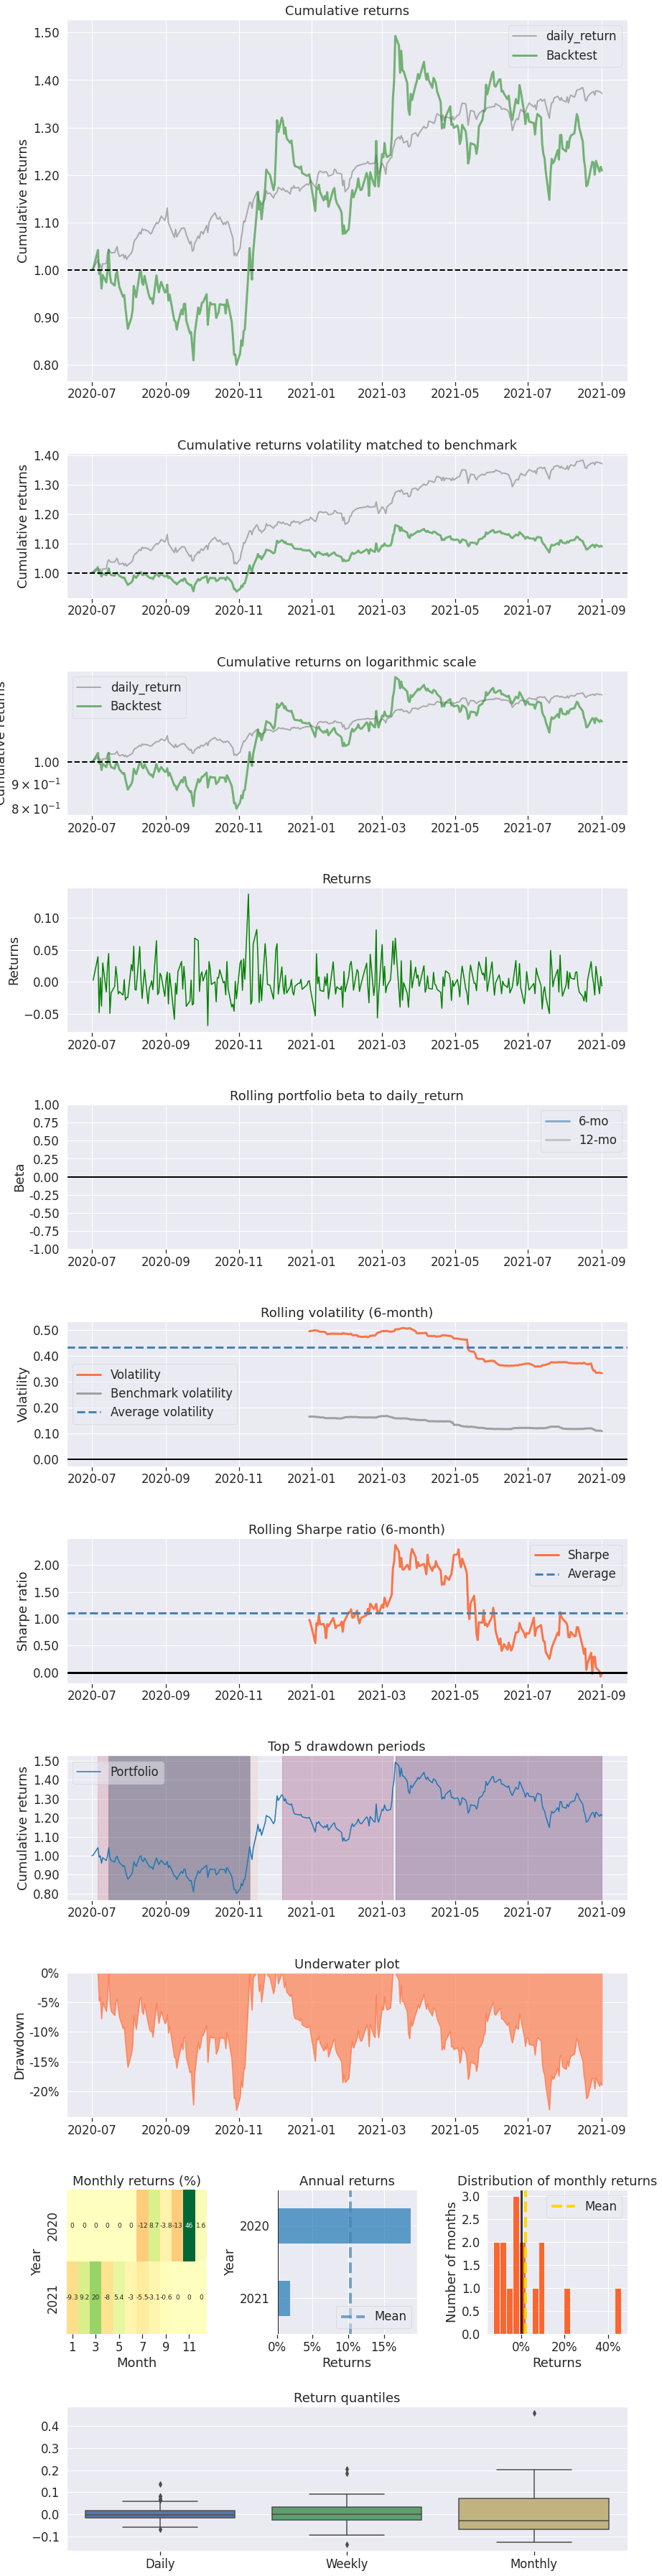

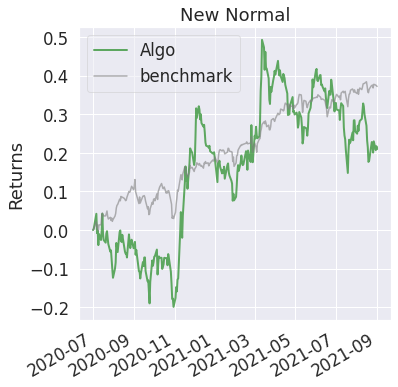

In [19]:
evaluator.backtest_plot(baseline_ticker="^DJI")

In [38]:
#Save model
lr.save_model("lr_model")

Model saved succesfully.


In [39]:
#Load model
my_model = lr.load_model("lr_model")

Model loaded succesfully.
